In [1]:
import subprocess
import sys
import os
import torch
from pathlib import Path

ROOT_DIR = Path("/content/toy-transformers")
EXPERIMENT_DIR = ROOT_DIR / "experiments/gptv3-simplebooks-colab"
# install repo
if not ROOT_DIR.exists():
	subprocess.run([
		"git", "clone", "--depth", "1", 
		"https://github.com/sselvakumaran/toy-transformers.git",
		str(ROOT_DIR)
	], check=True)

if str(ROOT_DIR) not in sys.path:
	sys.path.insert(0, str(ROOT_DIR))

# install seaborn
subprocess.run(
	[sys.executable, '-m', 'pip', 'install', 'seaborn', '--quiet'], 
	check=True
)

from toy_transformers.models import gptv3
from toy_transformers import tokenization
from toy_transformers import checkpoint

In [ ]:
# download simplebooks dataset
import shutil
from google.colab import drive
import urllib.request
import zipfile
drive.mount("/content/drive")

DRIVE_BASE = Path("/content/drive/MyDrive/toy-transformers")
DRIVE_RAW_DIR = DRIVE_BASE / "data/raw/simplebooks/simplebooks-92-raw"
LOCAL_RAW_DIR = ROOT_DIR / "data/raw/simplebooks/simplebooks-92-raw"

if not LOCAL_RAW_DIR.exists():
	if (DRIVE_RAW_DIR / "train.txt").exists():
		print("copying dataset from drive...")
		shutil.copytree(DRIVE_RAW_DIR, LOCAL_RAW_DIR)
	else:
		print("downloading simplebooks...")
		zip_path = Path("/tmp/simplebooks.zip")
		urllib.request.urlretrieve(
			"https://dldata-public.s3.us-east-2.amazonaws.com/simplebooks.zip",
			zip_path,
			lambda n, bs, total: print(
				f"\r  {n*bs/1e6:.1f}/{total/1e6:.1f} MB", end="", flush=True)
		)
		
		print("\nextracting...")
		with zipfile.ZipFile(zip_path, "r") as zf:
			zf.extractall(LOCAL_RAW_DIR.parent.parent)
		zip_path.unlink()
		
		# note: this only saves simplebooks-92-raw, not any of the others
		print("saving to drive...")
		shutil.copytree(LOCAL_RAW_DIR, DRIVE_RAW_DIR, dirs_exist_ok=True)
else:
	print("dataset retrieved locally")

for split in ["train.txt", "valid.txt", "test.txt"]:
	size_mb = (LOCAL_RAW_DIR / split).stat().st_size / 1e6
	print(f"  {split}: {size_mb:.1f} MB")

DRIVE_EXPERIMENT_DIR = DRIVE_BASE / "experiments/gptv3-simplebooks-colab"
# copy experiment checkpoints + data
if DRIVE_EXPERIMENT_DIR.exists():
	shutil.copytree(DRIVE_EXPERIMENT_DIR, EXPERIMENT_DIR)

Mounted at /content/drive
copying dataset from drive...
  train.txt: 407.4 MB
  valid.txt: 0.9 MB
  test.txt: 0.9 MB


In [3]:
VOCAB_SIZE = 4096
BATCH_SIZE = 16
GRAD_ACCUM_STEPS = 2
MODE = tokenization.TokenizationMode.STR
DEVICE = "cuda"

MAX_LR = 3e-4
MIN_LR = 3e-5
WARMUP_STEPS = 500
NUM_EPOCHS = 10

EVAL_INTERVAL = 100
EVAL_BATCHES = 20
LOG_INTERVAL = 10

config = gptv3.GPTv3Config(
	vocab_size=VOCAB_SIZE,
	block_size=512,
	device=DEVICE,
	n_heads=8,
	n_embed=512,
	n_layers=8
)

In [ ]:
vocab_path = EXPERIMENT_DIR / f"data/vocab_{VOCAB_SIZE}.json"
DATA_DIR = ROOT_DIR / "data/raw/simplebooks/simplebooks-92-raw"
TRAIN_PATH = DATA_DIR / "train.txt"
VALID_PATH = DATA_DIR / "valid.txt"
TEST_PATH = DATA_DIR / "test.txt"

if not vocab_path.exists():
	raw_data = open(TRAIN_PATH, "r")
	vocab = tokenization.create_bpe(
		raw_data, 
		VOCAB_SIZE, MODE
	)
	vocab.save(vocab_path)
	shutil.copy2(vocab_path, DRIVE_EXPERIMENT_DIR / f"data/vocab_{VOCAB_SIZE}.json")
else:
	shutil.copy2(DRIVE_EXPERIMENT_DIR / f"data/vocab_{VOCAB_SIZE}.json", vocab_path)
	vocab = tokenization.Vocabulary.load(vocab_path)

In [6]:
def cache_and_tokenize(text_path: Path, cache_path: Path, vocab: tokenization.Vocabulary) -> torch.Tensor:
	if cache_path.exists():
		print("loading from cache")
		return torch.load(cache_path, weights_only=True)
	print("tokenizing...")
	text = open(text_path, "r").read()
	tokens = torch.tensor(vocab.encode(text), dtype=torch.long)
	torch.save(tokens, cache_path)
	return tokens

train_tokens = cache_and_tokenize(TRAIN_PATH, EXPERIMENT_DIR / "data/train.pt", vocab)
val_tokens = cache_and_tokenize(VALID_PATH, EXPERIMENT_DIR / "data/valid.pt", vocab)
test_tokens = cache_and_tokenize(TEST_PATH, EXPERIMENT_DIR / "data/test.pt", vocab)

# write to drive
for split in ["data/train.pt", "data/valid.pt", "data/test.pt"]:
	if not (DRIVE_EXPERIMENT_DIR / split).exists():
		print(f"writing '{split}' to drive...")
		shutil.copy2(EXPERIMENT_DIR / split, DRIVE_EXPERIMENT_DIR / split)

tokenizing...
tokenizing...
tokenizing...
writing 'data/train.pt' to drive...
writing 'data/valid.pt' to drive...
writing 'data/test.pt' to drive...


In [7]:
from torch.utils.data import Dataset, DataLoader

block_size = config.block_size

class TokenChunkDataset(Dataset):
	def __init__(self, tokens: torch.Tensor, block_size: int):
		self.tokens = tokens
		self.block_size = block_size
		self.n_chunks = (len(tokens) - 1) // block_size
	
	def __len__(self):
		return self.n_chunks

	def __getitem__(self, idx):
		offset = idx * self.block_size
		x = self.tokens[offset : offset + self.block_size]
		y = self.tokens[offset + 1 : offset + block_size + 1]
		return x, y

train_ds = TokenChunkDataset(train_tokens, block_size)
val_ds = TokenChunkDataset(val_tokens, block_size)
test_ds = TokenChunkDataset(test_tokens, block_size)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=True, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=True, pin_memory=True)

steps_per_epoch = len(train_loader) // GRAD_ACCUM_STEPS
TOTAL_STEPS = steps_per_epoch * NUM_EPOCHS

@torch.no_grad
def estimate_loss(model, loader, n_batches=EVAL_BATCHES):
	model.eval()
	losses = []
	for i, (X, Y) in enumerate(loader):
		if i >= n_batches: break
		X, Y = X.to(DEVICE), Y.to(DEVICE)
		with torch.autocast(device_type=DEVICE, dtype=torch.bfloat16):
			_, loss = model(X, Y)
		losses.append(loss.item())
	model.train()
	return sum(losses) / len(losses)

print(f"{len(train_ds):,} training chunks")
print(f"{len(train_loader):,} batches per epoch")
print(f"{steps_per_epoch:,} steps per epoch")
print(f"{TOTAL_STEPS:,} total steps")
print(f"{BATCH_SIZE * GRAD_ACCUM_STEPS * block_size:,} tokens per step")

214,125 training chunks
13,382 batches per epoch
6,691 steps per epoch
66,910 total steps
16,384 tokens per step


In [9]:
import time
torch.set_float32_matmul_precision("medium")
m = gptv3.LanguageModel(config).to(device=DEVICE)
print(f"{m.get_num_parameters(as_str=True)} parameters")
m.compile()

optimizer = m.get_optimizer(weight_decay=0.1, lr=MAX_LR)

scheduler = torch.optim.lr_scheduler.SequentialLR(
	optimizer,
	schedulers=[
		torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=1/WARMUP_STEPS, total_iters=WARMUP_STEPS),
		torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=TOTAL_STEPS - WARMUP_STEPS, eta_min=MIN_LR),
	],
	milestones=[WARMUP_STEPS],
)

CKPT_DIR: Path = EXPERIMENT_DIR / "checkpoints"
TEMP_CKPT = CKPT_DIR / "temp"
TRAINING_CONFIG = {
	"max_lr": MAX_LR,
	"min_lr": MIN_LR,
	"warmup_steps": WARMUP_STEPS,
	"num_epochs": NUM_EPOCHS,
	"total_steps": TOTAL_STEPS,
	"steps_per_epoch": steps_per_epoch,
	"batch_size": BATCH_SIZE,
	"grad_accum_steps": GRAD_ACCUM_STEPS,
	"effective_batch_tokens": BATCH_SIZE * GRAD_ACCUM_STEPS * config.block_size,
	"vocab_path": str(vocab_path),
}

# every TEMP_SAVE_INTERVAL epochs, will save to 'temp' (in case of silent timeout)
TEMP_SAVE_INTERVAL = 500

def to_drive_path(local_path: Path):
  return DRIVE_BASE / local_path.relative_to(ROOT_DIR)

def to_local_path(drive_path: Path):
   return ROOT_DIR / drive_path.relative_to(DRIVE_BASE)

def checkpoint_save_drive(
  path: str | Path,
	model,
	model_config,
	training_config: dict,
	metrics: list[dict],
	optimizer=None, scheduler=None
):
  checkpoint.save(
    path, model, 
    model_config, training_config, 
    metrics, 
    optimizer=optimizer, scheduler=scheduler
  )
  # write to drive
  shutil.copytree(path, to_drive_path(path), dirs_exist_ok=True)

27.309m parameters


In [ ]:
metrics = []
step = 0
best_val_loss = float("inf")
if TEMP_CKPT.exists():
	print("resuming from temp checkpoint...")
	# this only loads local temp checkpoint!!
	loaded_model, _, _, saved_metrics, opt_state, sched_state = checkpoint.load(
		TEMP_CKPT, gptv3.LanguageModel, gptv3.GPTv3Config, device=DEVICE
	)
	m.load_state_dict(loaded_model.state_dict())
	if opt_state: optimizer.load_state_dict(opt_state)
	if sched_state: scheduler.load_state_dict(sched_state)
	if saved_metrics:
		metrics = saved_metrics
		step = metrics[-1].get("step", 0)
		val_losses = [row["val_loss"] for row in metrics if "val_loss" in row and row["val_loss"]]
		if val_losses: best_val_loss = min(val_losses)
else:
	print("starting fresh")

m.train()
t0 = time.time()
start_epoch = step // steps_per_epoch

try:
	for epoch in range(start_epoch, NUM_EPOCHS):
		print(f"--- epoch {epoch+1}/{NUM_EPOCHS} (step {step:,}/{TOTAL_STEPS:,}) ---")

		micro_batch_buffer = []
		epoch_step = 0
		batches_into_epoch = (step % steps_per_epoch) * GRAD_ACCUM_STEPS

		for xb, yb in train_loader:
			# skip batches already done this epoch when resuming
			epoch_step += 1
			if epoch_step <= batches_into_epoch: continue

			# accumulate items
			xb, yb = xb.to(DEVICE), yb.to(DEVICE)
			micro_batch_buffer.append((xb, yb))
			if len(micro_batch_buffer) < GRAD_ACCUM_STEPS: continue

			# train batch
			optimizer.zero_grad(set_to_none=True)
			loss_accum = 0.0

			for micro_xb, micro_yb in micro_batch_buffer:
				# note: no bfloat autocast, Colab GPUS does not support
				_, loss = m(micro_xb, micro_yb)
				loss = loss / GRAD_ACCUM_STEPS
				loss.backward()
				loss_accum += loss.item()
			
			# update after batch
			torch.nn.utils.clip_grad_norm_(m.parameters(), 1.0)
			optimizer.step()
			scheduler.step()
			step += 1
			micro_batch_buffer = []

			# logging
			if step % LOG_INTERVAL == 0:
				dt = time.time() - t0
				tokens_per_sec = (LOG_INTERVAL * BATCH_SIZE * GRAD_ACCUM_STEPS * block_size) / dt
				lr = scheduler.get_last_lr()[0]
				row = {"step": step, "epoch": epoch+1, "train_loss": loss_accum, "lr": lr}
				print(f"step {step:5d} | epoch {epoch+1:2d} | loss {loss_accum:.4f} | lr {lr:.2e} | tok/s {tokens_per_sec:.0f}")
				metrics.append(row)
				t0 = time.time()
			
			if step % EVAL_INTERVAL == 0:
				val_loss = estimate_loss(m, val_loader)
				print(f"\t>>> val_loss: {val_loss:.4f}, best: {best_val_loss:.4f}")
				if metrics:
					metrics[-1]["val_loss"] = val_loss
				if val_loss < best_val_loss:
					best_val_loss = val_loss
				t0 = time.time()
			
			if step % TEMP_SAVE_INTERVAL == 0:
				checkpoint_save_drive(
					TEMP_CKPT, m, 
					config, TRAINING_CONFIG, 
					metrics, 
					optimizer=optimizer, scheduler=scheduler
				)
	
	checkpoint_save_drive(
		CKPT_DIR / f"epoch-{epoch}", 
		m, config, TRAINING_CONFIG, 
		metrics, 
		optimizer=optimizer, scheduler=scheduler
	)

except KeyboardInterrupt:
	print(f"interrupted at step {step}, saving...")
	
	checkpoint_save_drive(
		TEMP_CKPT, 
		m, config, TRAINING_CONFIG, 
		metrics, 
		optimizer=optimizer, scheduler=scheduler
	)
	print("saved!")

resuming from temp checkpoint...
--- epoch 1/10 (step 0/66,910) ---
step    10 | epoch  1 | loss 7.9193 | lr 7.79e-06 | tok/s 18425
step    20 | epoch  1 | loss 7.6633 | lr 1.38e-05 | tok/s 18376
step    30 | epoch  1 | loss 7.5126 | lr 1.98e-05 | tok/s 18228
step    40 | epoch  1 | loss 7.3829 | lr 2.57e-05 | tok/s 18054
step    50 | epoch  1 | loss 7.1944 | lr 3.17e-05 | tok/s 17948
step    60 | epoch  1 | loss 6.9976 | lr 3.77e-05 | tok/s 17768
step    70 | epoch  1 | loss 6.7945 | lr 4.37e-05 | tok/s 17667
step    80 | epoch  1 | loss 6.6527 | lr 4.97e-05 | tok/s 17530
step    90 | epoch  1 | loss 6.4923 | lr 5.57e-05 | tok/s 17420
step   100 | epoch  1 | loss 6.2882 | lr 6.17e-05 | tok/s 17308
	>>> val_loss: 6.1482, best: inf
step   110 | epoch  1 | loss 6.2137 | lr 6.77e-05 | tok/s 17180
step   120 | epoch  1 | loss 6.0691 | lr 7.37e-05 | tok/s 17126
step   130 | epoch  1 | loss 5.9534 | lr 7.96e-05 | tok/s 17037
step   140 | epoch  1 | loss 5.8468 | lr 8.56e-05 | tok/s 16985
ste

In [11]:
test_loss = estimate_loss(m, test_loader, n_batches=50)
print(f"test loss: {test_loss:.4f}")

test loss: 3.3476


In [ ]:
prompt = "Once upon a time "
idx = torch.tensor([vocab.encode(prompt)], dtype=torch.long, device=DEVICE)
print(prompt, end="", flush=True)
for token in m.generate(idx, max_new_tokens=300, temperature=0.8, topk=40):
	print(vocab.decode([token.item()])[0], end="", flush=True)
print()

Once upon a time 

/Users/sselva890@cable.comcast.com/dev/apps/toy-transformers/venv/lib/python3.11/site-packages/torch/_dynamo/utils.py:3421: UserWarning: record_context_cpp is not support on non-linux non-x86_64 platforms (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/profiler/unwind/unwind.cpp:12.)
  return node.target(*args, **kwargs)


 he had the slightest experience to meet with no particular sympathetic characteristicness and he was now to be a little older He was a boy of one who could not read about himself and himself

Before a time had passed the latter's name appeared to be one of the most extraordinary things whom he said was to be in his place He was not so long as he was in the house for a few days He knew he would enjoy a good friend and he was just about as good as a child as he is to be

But though he was going to give a little while he did not know that he would let the little boy who had been sent to a place where he would be able to find the place of a traitor

He did not mean to look at the place at both end of the country He had been in some kind of a country house and had brought with him a hundred dollars for there was a real place and he had a lot of money for money He tried to manage it in the land for himself

The last boy would have to give two dollars He was just two years old and I know he 

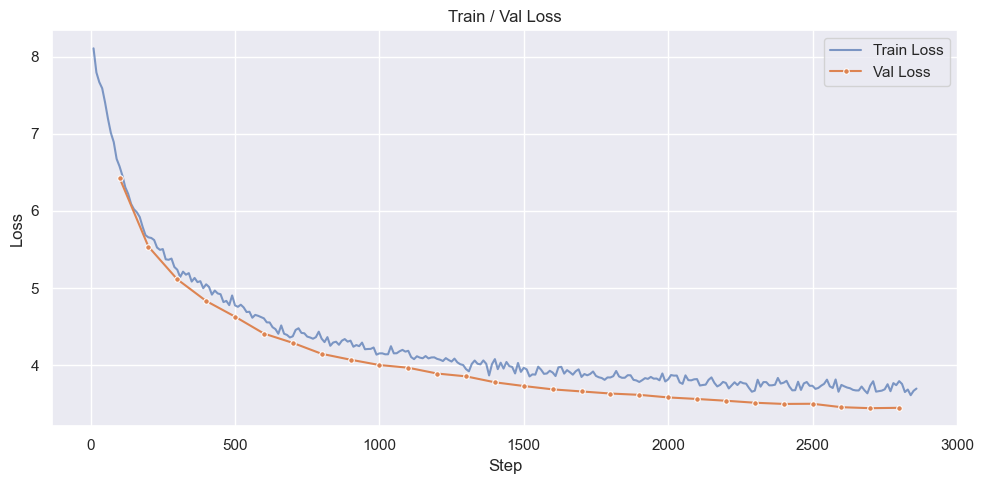

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="darkgrid")

steps = [row["step"] for row in metrics]
train_loss = [row["train_loss"] for row in metrics]
val_steps = [row["step"] for row in metrics if "val_loss" in row]
val_loss = [row["val_loss"] for row in metrics if "val_loss" in row]

fig, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(x=steps, y=train_loss, label="Train Loss", ax=ax, alpha=0.7)
sns.lineplot(x=val_steps, y=val_loss, label="Val Loss", ax=ax, marker="o", markersize=4)

ax.set_xlabel("Step")
ax.set_ylabel("Loss")
ax.set_title("Train / Val Loss")
plt.tight_layout()
plt.show()